[  0%] Reading plotfile /home/christian/FVS_develop/FiniteVolumeSolver/build_Release_2d_EB/SEC_Plenum/Plotfiles/Plenum0/plt000000000


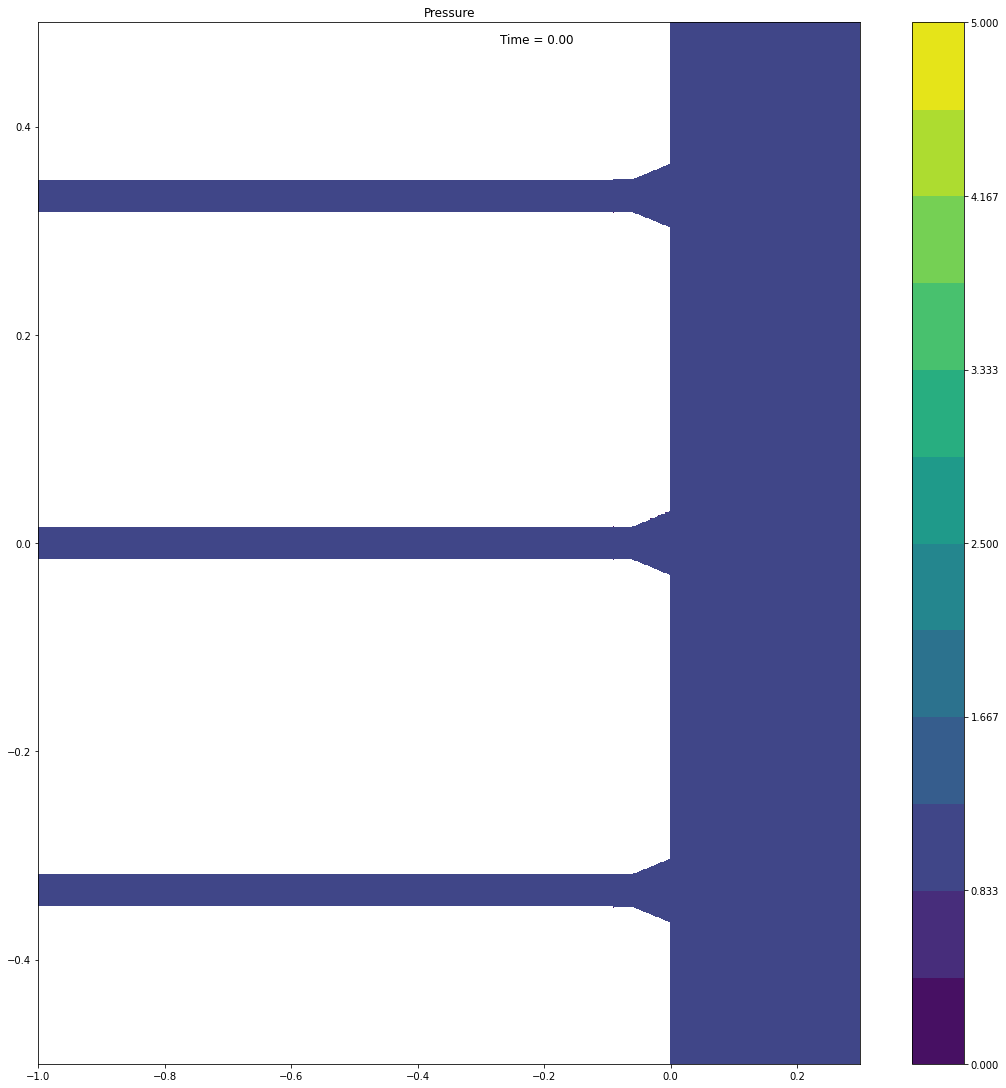

[ 20%] Reading plotfile /home/christian/FVS_develop/FiniteVolumeSolver/build_Release_2d_EB/SEC_Plenum/Plotfiles/Plenum0/plt000000032


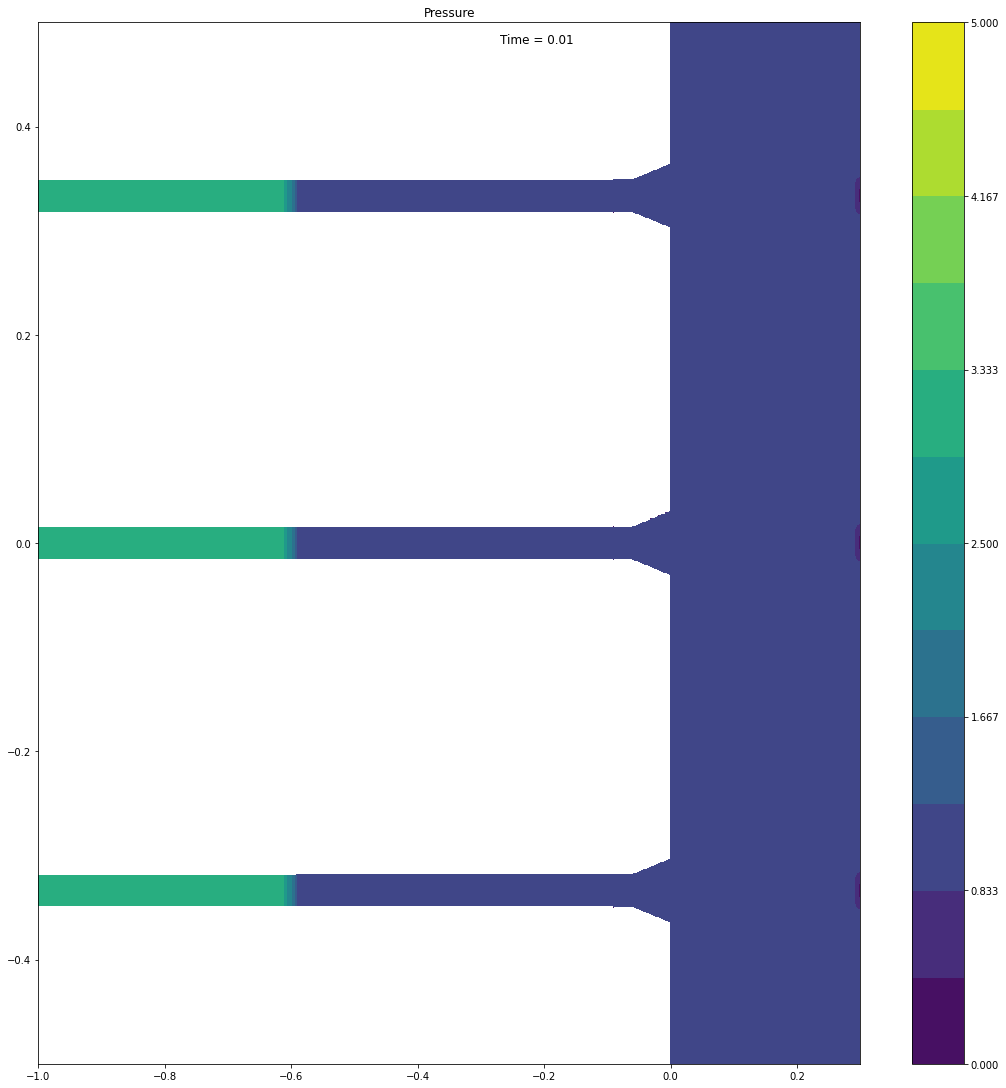

[ 40%] Reading plotfile /home/christian/FVS_develop/FiniteVolumeSolver/build_Release_2d_EB/SEC_Plenum/Plotfiles/Plenum0/plt000000069


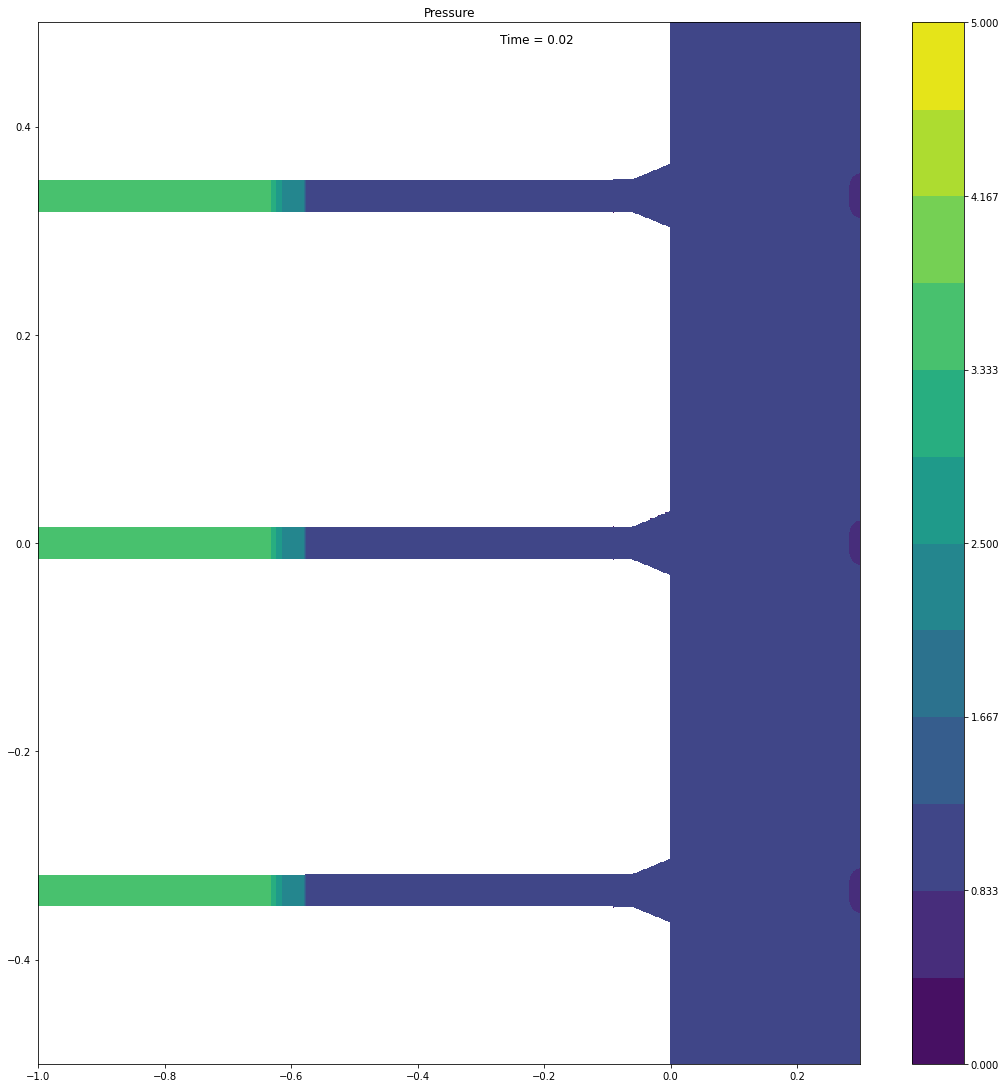

[ 60%] Reading plotfile /home/christian/FVS_develop/FiniteVolumeSolver/build_Release_2d_EB/SEC_Plenum/Plotfiles/Plenum0/plt000000108


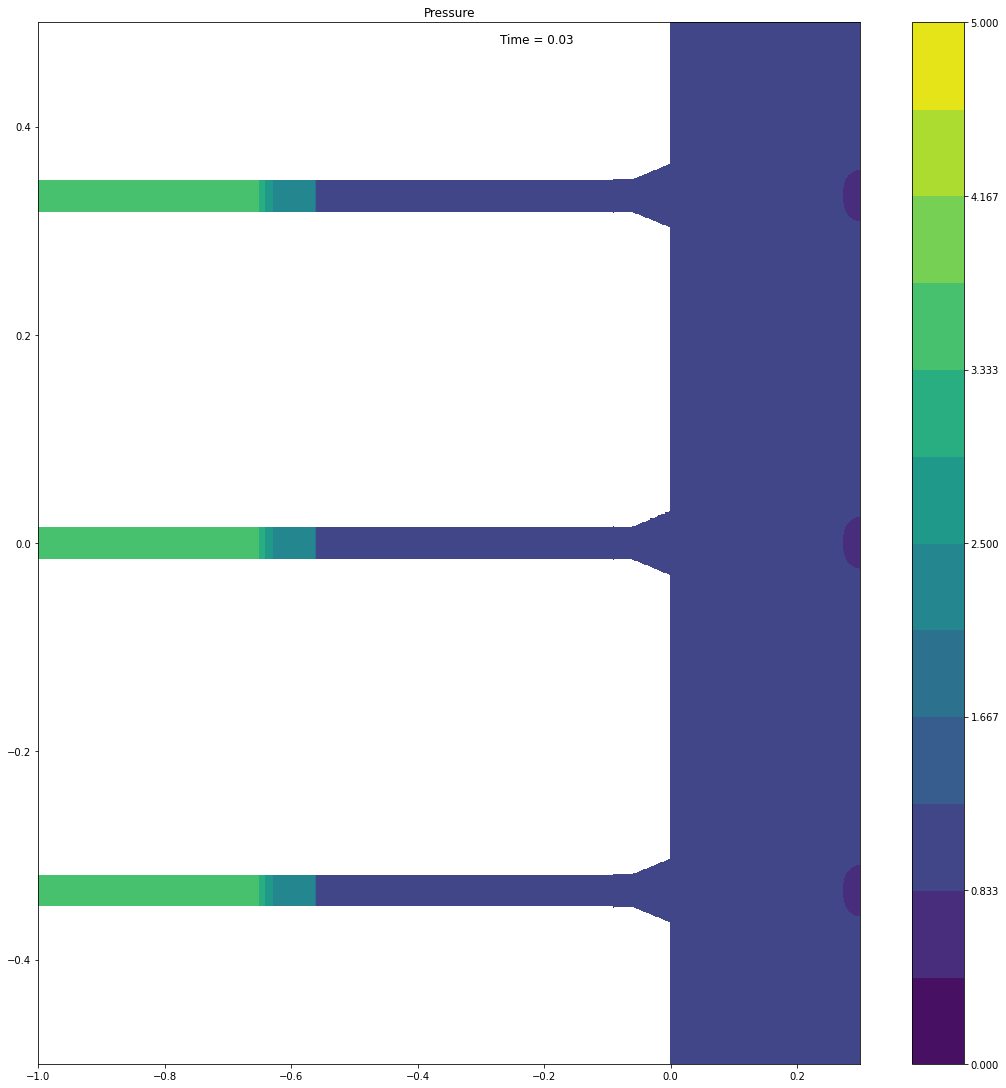

[ 80%] Reading plotfile /home/christian/FVS_develop/FiniteVolumeSolver/build_Release_2d_EB/SEC_Plenum/Plotfiles/Plenum0/plt000000147


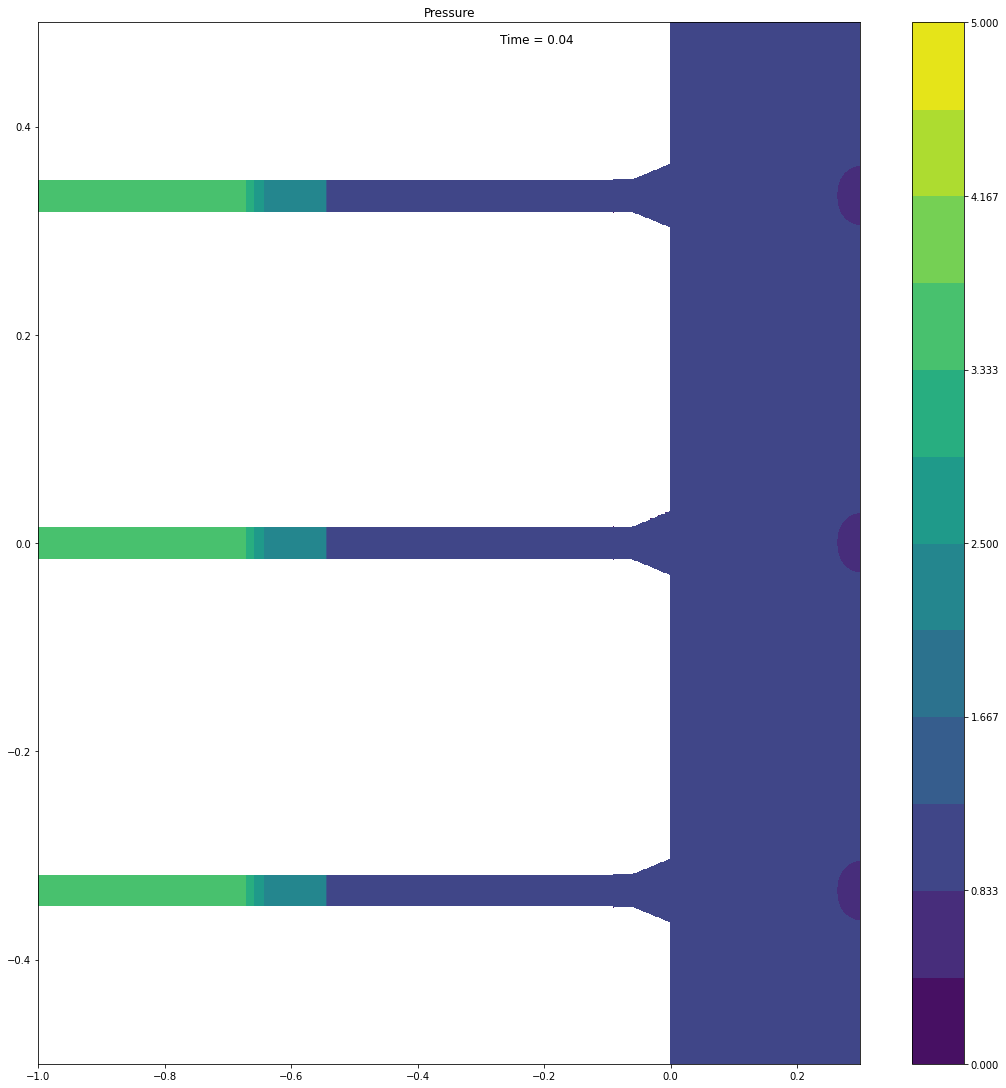

[100%] Reading plotfile /home/christian/FVS_develop/FiniteVolumeSolver/build_Release_2d_EB/SEC_Plenum/Plotfiles/Plenum0/plt000000186


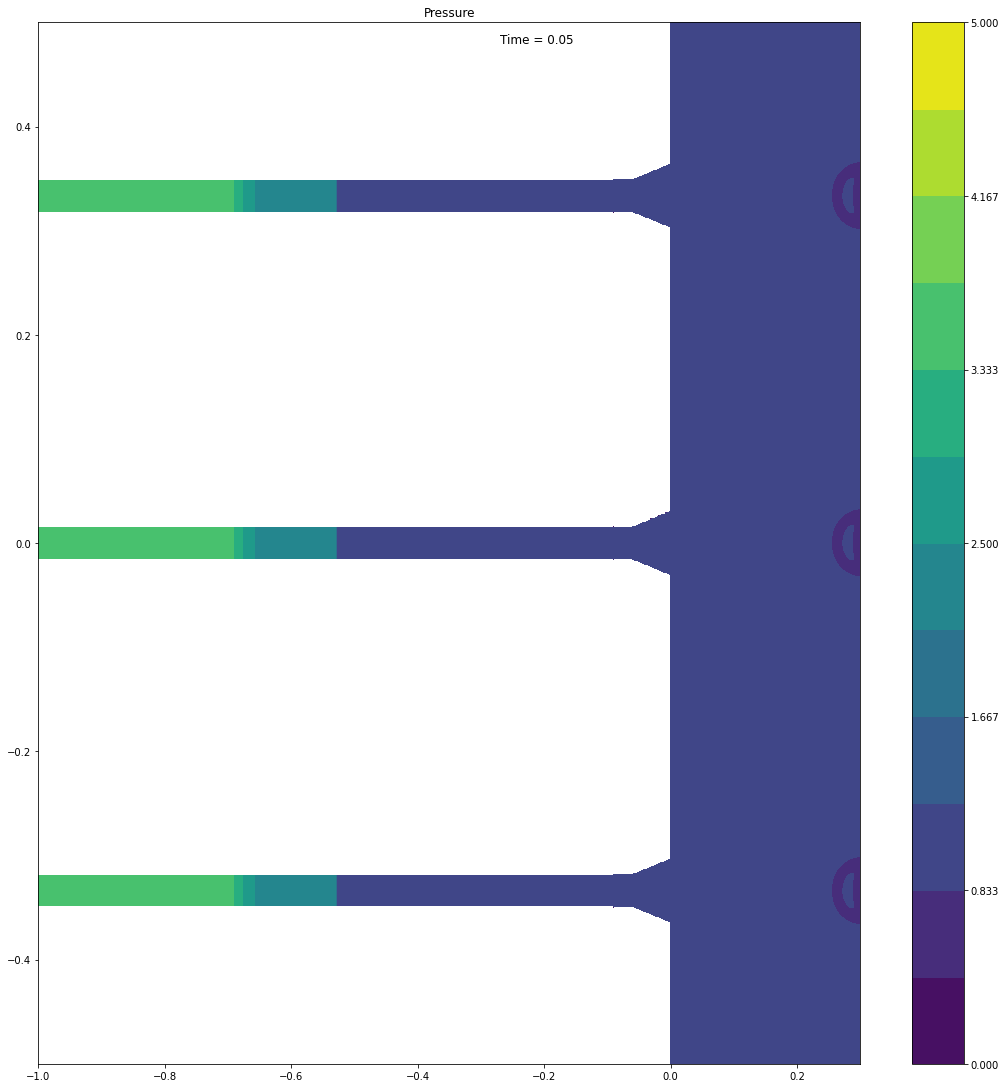

In [38]:
import yt
import os
import numpy as np
import matplotlib.pyplot as plt

valueString = 'Pressure' # which value we want to plot
# possible values are: ['Density', 'Energy', 'Momentum_0', 'Momentum_1', 'Pressure', 'Species_0', 'Species_1', 'SpeedOfSound', 'vfrac']

# dataPath = "/srv/public/Maikel/FiniteVolumeSolver/build_2D-Release/SEC_Plenum_TurbineBoundary/"
dataPath = "/home/christian/FVS_develop/FiniteVolumeSolver/build_Release_2d_EB/SEC_Plenum"
plenum_number = 0
MASK_DATA_WITH_VFRAC = True
vfrac_cutoff = 1.0e-16

def loadData(plotfile, vars, MASK_DATA_WITH_VFRAC=True):
  ds = yt.load(plotfile)
  ytplt = yt.plot_2d(ds, vars, origin='native')
  ytplt.set_buff_size((ds.domain_dimensions[0], ds.domain_dimensions[1]))
  ad = ds.all_data()
  current_time = ds.current_time
  datas = [np.squeeze(np.array(ytplt.frb[var])) for var in vars]
  if MASK_DATA_WITH_VFRAC:
    vfrac = np.array(ytplt.frb["vfrac"])
    vfrac = np.squeeze(vfrac)
    datas = [np.ma.masked_where( vfrac<=vfrac_cutoff, data) for data in datas]
  return datas, current_time, np.array(ytplt.bounds)

def PrintProgress(i, plotfiles):
  ny = len(plotfiles)
  progress = int(100.0 * float(i) / (ny - 1))
  print('[{:3d}%] Reading plotfile {}'.format(progress, plotfiles[i]))

yt.funcs.mylog.setLevel(50)
output_dir = dataPath+'/Plotfiles/Plenum%i'%(plenum_number)

dirs = os.listdir(output_dir)
plotfiles = ['{}/{}'.format(output_dir, plt) for plt in dirs]
list.sort(plotfiles)
plotfiles = plotfiles[:]

output_path = '{}/Visualization/Plenum{}_{}/'.format(dataPath, plenum_number, "Pressure")
os.makedirs(output_path, exist_ok=True)

output_path_quiv = '{}/Visualization/Plenum{}_{}/'.format(dataPath, plenum_number, "Quiver")
os.makedirs(output_path_quiv, exist_ok=True)

output_path_temp = '{}/Visualization/Plenum{}_{}/'.format(dataPath, plenum_number, "Temperature")
os.makedirs(output_path_temp, exist_ok=True)


for i, plotfile in enumerate(plotfiles):
   PrintProgress(i, plotfiles)
   
   # get Tube Data
   temp = plotfile.split("/")[-1]
   Tubes = [0,1,2]
   
   Tube_p = []
   Tube_rho = []
   Tube_c = []
   extent_tube = []
   
   for tube_number in Tubes:
      Tube_Dir = dataPath+'/Plotfiles/Tube%i/'%tube_number
      (p_tube, rho_tube, c_tube), current_time, extent_temp = loadData(Tube_Dir+temp, ["Pressure", "Density", "SpeedOfSound"], False)
   
      Tube_p.append(p_tube)
      Tube_rho.append(rho_tube)
      Tube_c.append(c_tube)
      extent_tube.append(extent_temp)
   
   
   def stackTubeDataTo2D(Tube_datalist):
     # all Tubedata is 1D but for contourf we need at least 2D data. so simply stack twice the 1d array
     for i, el in enumerate(Tube_datalist):
        Tube_datalist[i] = np.stack((el,el))
     return Tube_datalist
   
   Tube_p = stackTubeDataTo2D(Tube_p)
   Tube_rho = stackTubeDataTo2D(Tube_rho)
   

   # get Plenum data
   (p, rho, rhou, rhov, c), current_time, extent = loadData(plotfile, ["Pressure", "Density", "Momentum_0", "Momentum_1", "SpeedOfSound"])

   nlevel = 13
   vmin = 0.
   vmax = 5.0

   f, axs = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
   #f, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
   f.suptitle('Time = {:.2f}'.format(float(current_time)))
   
   levels = np.linspace(vmin, vmax, nlevel)
   # pressure image
   im_p = axs.contourf(p, extent=extent, interpolation='none', levels=levels)
   
   for i, el in enumerate(Tube_p):
      axs.contourf(el, extent=extent_tube[i], interpolation='none', aspect='auto', levels=levels)
   
   #axs[0].imshow(p, origin='lower', vmin=0.0, vmax=3.0, interpolation='none', extent=extent)
   axs.set_aspect('auto')
   plt.tight_layout()
   axs.set_title('Pressure')
   plt.colorbar(im_p, ax=axs)
   # temperature image
   #T = p / rho
   #im_T = axs[1].imshow(T, origin='lower', vmin=0.0, vmax=3.0, interpolation='none', extent=extent)
   #im_T = axs[1].contourf(X, Y, T, interpolation='none', vmin=vmin, vmax=vmax)
   #im_T2 = axs[1].contourf(X_tube, Y_tube, p_tube / rho_tube, interpolation='none',  aspect='auto',vmin=vmin, vmax=vmax)
   #axs[1].set_title('Temperature')
   #axs[1].set(ylim=(extent[2], -0.2))
   #plt.colorbar(im_T, ax=axs[1])
   ## velocity field
   #u = rhou / rho
   #v = rhov / rho
   #skip = 20
   #scale = 0.2
   #axs[2].quiver(u[::skip], v[::skip], scale=scale, units='xy')
   #axs[2].set_title('Velocity Field')
   plt.show()
   f.savefig(output_path+"/"+temp+".png")
   f.clf()

In [ ]:
import yt
import os
import numpy as np
import matplotlib.pyplot as plt


Path = "/home/christian/FVS_develop/FiniteVolumeSolver/build_Release_2d_EB/SEC_Plenum/"

yt.funcs.mylog.setLevel(50)

tube_numbers = [0, 1 ,2 ]
MASK_DATA_WITH_VFRAC = True
vfrac_cutoff = 1.0e-16


def KlebeRichtigZusammen(ad, var):
  xs = [float(grid.LeftEdge[0]) for grid in ad.index.grids]
  enumerated = list(enumerate(xs))
  sorted_keys = [k for (k,v) in sorted(enumerated, key=lambda xs: xs[1])]
  grids = [np.array(ad.index.grids[k][var]) for k in sorted_keys]
  grids = [x.reshape((x.shape[0],)) for x in grids]
  p = np.concatenate(grids)
  return p

def PrintProgress(i, plotfiles):
  ny = len(plotfiles)
  progress = int(100.0 * float(i) / (ny - 1))
  print('[{:3d}%] Reading plotfile {}'.format(progress, plotfiles[i]))

#dataPath = '/group/ag_klima/SFB1029_C01/SEC_Plenum/Plotfiles/Tube1'

dataPath = Path+"Plotfiles/Tube%i"%(tube_numbers[0])
dirs = os.listdir(dataPath)
plotfiles = ['{}/{}'.format(dataPath, plt) for plt in dirs]
list.sort(plotfiles)
plotfiles = plotfiles[:]
ds = yt.load(plotfiles[0])

# print(ds.index.grids[0])

ad = ds.all_data()
p = KlebeRichtigZusammen(ad, 'Pressure')


nx = p.shape[0]
ny = 2 # len(plotfiles)


PrintProgress(0, plotfiles)
x0 = ad.index.grids[0].LeftEdge[0]
xEnd = ad.index.grids[-1].RightEdge[0]
ts = np.zeros((ny,1))
ts[0] = ds.current_time
imdata = np.zeros(shape=(nx, ny))
imdata[:,0] = p

# disable logging to prevent spam
for i in range(1,ny):
  PrintProgress(i, plotfiles)
  ds = yt.load(plotfiles[i])
  ad = ds.all_data()
  p = KlebeRichtigZusammen(ad, 'Pressure')
  imdata[:,i] = p
  ts[i] = ds.current_time


In [ ]:
def plotContourf(plotfile, valueString, imdata, current_time, vmin, vmax):
  
  fig, ax = plt.subplots(figsize=(10,10))
  
  x = np.linspace(LeftEgdes[0], RightEdges[0], num=imdata.shape[0], endpoint=True)
  y = np.linspace(LeftEgdes[1], RightEdges[1], num=imdata.shape[1], endpoint=True)
  X, Y = np.meshgrid(x,y)
  im = ax.contourf(X, Y, imdata.T, interpolation='none', aspect='auto', vmin=vmin, vmax=vmax)
  cbar = ax.colorbar(im)
  cbar.set_label(valueString)
  plt.title("time = %2.6f"%current_time)
  fig.savefig(output_path+valueString+"_"+plotfile.split("/")[-1]+".png" )
  fig.clf()
  plt.close(fig)